# Image2caption using LSTMs
_Making a NN caption images for you..._
## Introduction
In this notebook we train a neural network able to generate image captions. <br>
If you'd like to use the __trained model__ without going through the notebook, that can be found [here](https://drive.google.com/file/d/1P4wzJLqM6LZjj83FDrxBPopwdDLMf6xM/view?usp=sharing). <br>
If you'd like to train the model yourself, run all the cells in this notebook. At the end, the model will get saved under `./model/`.



In [1]:
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


### Training data download (subset of Michigan dataset)

In [2]:
data_path = './datasets/coco.pt'

if os.path.isfile(data_path):
  print('COCO dataset exist')
else:
  print('Downloading COCO dataset')
  !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in a4_helper.py
coco = torch.load(data_path)
for k, v in coco.items():
    print('coco[{}] = {}'.format(k, v.shape if type(v) == torch.Tensor else v.keys()))



--2022-02-14 17:06:57--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘./datasets/coco.pt’

coco.pt             100%[===================>] 378.21M  28.6MB/s    in 14s     

2022-02-14 17:07:11 (27.1 MB/s) - ‘./datasets/coco.pt’ saved [396583632/396583632]

coco[train_images] = torch.Size([10000, 3, 112, 112])
coco[train_captions] = torch.Size([10000, 17])
coco[val_images] = torch.Size([500, 3, 112, 112])
coco[val_captions] = torch.Size([500, 17])
coco[vocab] = dict_keys(['idx_to_token', 'token_to_idx'])


### Let's dig a little bit into the dataset

In [3]:
def make_caption(indexes, tables):
    """
    Makes caption from a given indexes
    """
    idx_to_token = tables['idx_to_token']
    end_idx = tables['token_to_idx']['<END>']

    caption = []
    for idx in indexes:
        caption.append(idx_to_token[idx])
        if idx == end_idx:
            break
    
    return ' '.join(caption)


NUM_TRAIN 10000
NUM_VAL 500


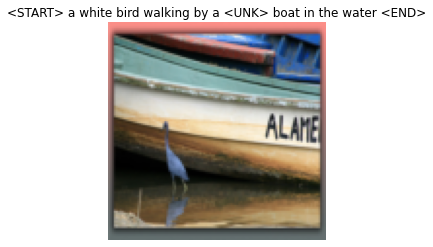

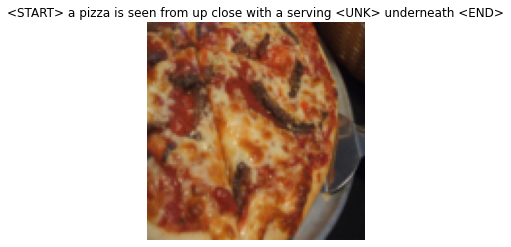

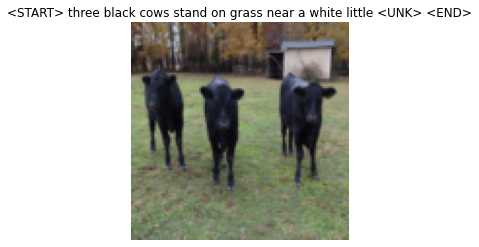

In [4]:
# Number of training and validation samples
NUM_TRAIN = coco['train_images'].shape[0]
NUM_VAL = coco['val_images'].shape[0]

# Get numerical representation of null and start token
NULL_IDX = coco['vocab']['token_to_idx']['<NULL>']
START_IDX = coco['vocab']['token_to_idx']['<START>']

# Plot a few example images 
num_samples = 3
selected_samples = torch.randint(NUM_TRAIN, (num_samples,))
sample_images = coco['train_images'][selected_samples]
sample_captions = coco['train_captions'][selected_samples]

print("NUM_TRAIN", NUM_TRAIN)
print("NUM_VAL", NUM_VAL)

for i in range(num_samples):
    fig, ax = plt.subplots()
    # Matplotlib expects (H, W, C), so we need to rearrange
    ax.imshow(sample_images[i].permute(1, 2, 0))
    ax.set_title(make_caption(sample_captions[i], coco['vocab']))
    ax.axis('off')
    fig.show()
    

### For the following operations we will need CUDA

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('You have CUDA device.')
else:
    device = 'cpu'
    print('Switch to GPU runtime to speed up computation.')


You have CUDA device.


We need a feature extractor which takes input images and extracts features on them

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # We only need the image feature so we can cut off the classifier
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.squeeze()
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

### Let's have a look at ResNet50

In [7]:
feature_extractor = FeatureExtractor()
summary(feature_extractor, (3, 112, 112), device='cpu')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           4,096
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,384
      BatchNorm2d-12          [-1, 256, 28, 28]             512
           Conv2d-13          [-1, 256, 28, 28]          16,384
      BatchNorm2d-14          [-1, 256,

### A utility function for feature extracting

In [8]:
def extract_features(x, device='cpu'):
    """
    Extract features from given images

    Args:
        x: tensor of images with shape of (N, 3, H, W). Pixel values are between
            0-255
        device: cuda or  cpu
    
    Returns:
        features: extracted features with shape of (N, D) where D is number of
            features. For ResNet50 it is 2048.
    """
    # Normalize images
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    normalized = []
    for i, image in enumerate(x):
        normalized.append(normalize(image.to(torch.float32).div(255.)))
    x = torch.stack(normalized)

    # Prepare for batching
    dataset = TensorDataset(x)
    data_loader = DataLoader(dataset, batch_size=128)

    feature_extractor = FeatureExtractor().to(device)
    features = []
    with torch.no_grad():
        for batch in data_loader:
            output = feature_extractor(batch[0].to(device))
            features.append(output.cpu())
    features = torch.cat(features)
    return features.detach()

We use a pretrained feature extractor. Thus, we don't need to train a feature extractor ourselves, and we can precompute the features for efficiency. 

In [9]:
# The features will have 2048 dimension
train_features = extract_features(coco['train_images'], device=device)
val_features = extract_features(coco['val_images'], device=device)

### We need to convert the datasets to more usable PyTorch datasets and dataloaders

In [10]:
train_dataset = TensorDataset(train_features, coco['train_captions'])
val_dataset = TensorDataset(val_features, coco['val_captions'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

Code that is in charge of creating image 2 tag

In [11]:
class CaptioningLSTM(nn.Module):

    def __init__(self, num_tokens, feature_size, embed_size, hidden_size):
        """
        Creates a captining model.

        Args:
            num_tokens: number of diffent tokens which is also known as
                vocabulary size
            feature_size: image feature dimension extracted from images with a
                feature extractor model.
            embed_size: vector dimension of word embeddings
            hidden_size: LSTM hidden state size
        """
        super(CaptioningLSTM, self).__init__()

        # Embedding layer, embeds each token into a vector
        self.embedding = nn.Embedding(num_tokens, embed_size)

        # Feature projector, projects image features to a hidden sized vector
        self.feature_projector = nn.Linear(feature_size, hidden_size)

        # LSTM layer, which will try to guess next word
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        # Output projector, projects hidden states to token scores
        self.output_projector = nn.Linear(hidden_size, num_tokens)

    def forward(self, features, captions):
        """
        Forward pass.

        Args:
            features: extracted image features with a shape of (N, D)  where N
                is batch size and D is number of features.
            captions: grand truth image captions with a shape of (N, M) where M
                is max caption length. If an image caption is less than max
                caption length it should be padded with <NULL> token.

        Returns:
            scores: token scores with a shape of (N, M, K) where K is number of
                tokens (num_tokens).
        """

        scores = None

        # Embed captions
        embeds = self.embedding(captions)

        # Create h0 from image features
        h0 = self.feature_projector(features).unsqueeze(0)

        # Set cell state to zeros
        c0 = torch.zeros_like(h0)

        # Calculate LTSM output
        output, _ = self.lstm(embeds, (h0, c0))

        # Project output to token scores
        scores = self.output_projector(output)

        return scores
    

    @torch.no_grad()
    def sample(self, features, start_idx, max_length):
        """
        Generates captions for each given image features.

        Args:
            features: image features with a shape of (N, D) where N is batch
                size and D is number of features.
            start_idx: start token (numerical representation of <START>).
            max_length: max sampling iteration.
        """
        # Project image features
        h0 = self.feature_projector(features).unsqueeze(0)

        # Set first token as <START> token
        token = torch.tensor([[start_idx]]*len(features), device=features.device)

        # Keep tokens, they are our generated captions and each captions
        # starts with <START> token
        captions = [token]

        for i in range(max_length):
            # Embed token
            embeds = self.embedding(token)

            # First iteration, so init hidden state and cell state
            # Hidden state will be projected image feature, cell state will
            # be zero
            if i == 0:
                h = h0
                c = torch.zeros_like(h0)
            
            # Get output and next cell and hidden states
            output, (h, c) = self.lstm(embeds, (h, c))

            # Project output to token scores
            scores = self.output_projector(output)

            # Get predictions, the predictions will be our next token,
            # because our LSTM tries to guess next token if we give it a
            # token
            token = torch.argmax(scores, dim=2)

            # Store the predictions
            captions.append(token)
        
        # Concatenate predicted tokens
        captions = torch.cat(captions, dim=1)

        return captions

Code that trains the network and saves the model

In [12]:
# Create a writer to write to Tensorboard
writer = SummaryWriter()

# Some hyperparams
epochs = 80
lr_decay = 1

# Number of different words in our vocabulary including special tokens <START>,
# <END>, <NULL> and <UNK>
num_tokens = len(coco['vocab']['idx_to_token'])

# Number of image features
feature_size = train_features.shape[-1]

# Word embedding vector size
embed_size = 512

# LSTM hidden state dimension
hidden_size = 1024

model = CaptioningLSTM(num_tokens, feature_size, embed_size, hidden_size)
model = model.to(device)

# Create loss function and optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss(ignore_index=NULL_IDX, reduction='sum')
optimizer = optim.Adam(model.parameters(), 1e-3)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)

for epoch in tqdm(range(epochs)):

    # Train one epoch
    train_loss = 0

    # Iterate through batches
    for features, captions in train_loader:
        # Move data to target device
        features, captions = features.to(device), captions.to(device)

        # Define input and target captions
        # Input captions will be fed into LSTM and target captions are used for
        # loss calculation as LTSM tries to guess next word
        input_captions, target_captions = captions[:, :-1], captions[:, 1:]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        output = model(features, input_captions)
        loss = criterion(output.transpose(1, 2), target_captions)
        loss.backward()
        optimizer.step()

        train_loss += loss
    
    # Write train loss to Tensorboard
    writer.add_scalars('Captioning Loss',
                        {'Train': train_loss / len(train_dataset)},
                        epoch)
    
    # Step learning rate scheduler after each epoch
    lr_scheduler.step()

    # Validate loss
    val_loss = 0

    with torch.no_grad():
        # Iterate through batches
        for features, captions in val_loader:
            # Move data to target device
            features, captions = features.to(device), captions.to(device)

            # Define input and target captions
            # Input captions will be fed into LSTM and target captions are used for
            # loss calculation as LTSM tries to guess next word
            input_captions, target_captions = captions[:, :-1], captions[:, 1:]
            output = model(features, input_captions)
            loss = criterion(output.transpose(1, 2), target_captions)

            val_loss += loss
        
        # Write loss to Tensorboard
        writer.add_scalars('Captioning Loss',
                            {'Validation': val_loss / len(val_dataset)},
                            epoch)

print('\nFinished.')
writer.flush()
writer.close()

100%|██████████| 80/80 [06:11<00:00,  4.65s/it]


Finished.


Let's plot a few images also with ground truth (from the training set)

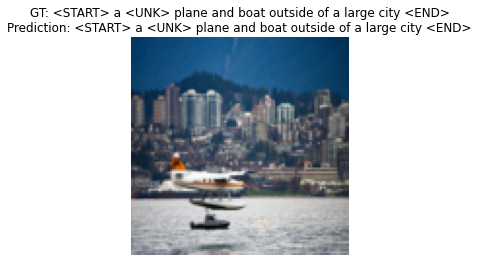

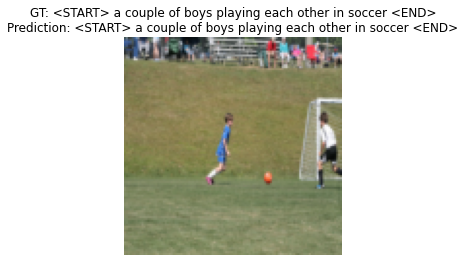

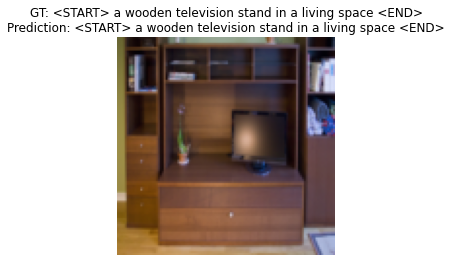

In [13]:
model.eval()

num_samples = 3
selected_samples = torch.randint(NUM_TRAIN, (num_samples,))
sample_images = coco['train_images'][selected_samples]
sample_captions = coco['train_captions'][selected_samples]

# Get features of selected sample images
features = torch.stack([train_dataset[i][0] for i in selected_samples])

# Move data to target device
features = features.to(device)

# Generate captions
predicted_captions = model.sample(features, START_IDX, 16)

for i in range(num_samples):
    fig, ax = plt.subplots()
    # Matplotlib expects (H, W, C), so we need to rearrange
    ax.imshow(sample_images[i].permute(1, 2, 0))
    title = 'GT: {}\nPrediction: {}'.format(
        make_caption(sample_captions[i], coco['vocab']),
        make_caption(predicted_captions[i], coco['vocab'])
    )
    ax.set_title(title)
    ax.axis('off')
    fig.show()

Let's plot the same images from the validation



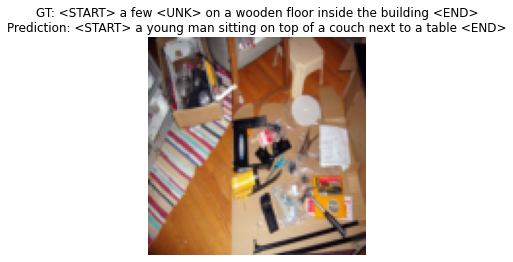

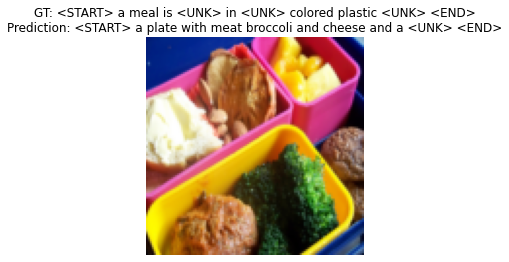

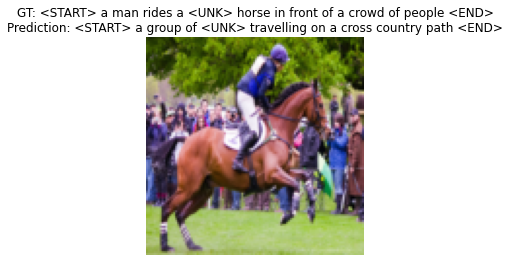

In [14]:
model.eval()

num_samples = 3
selected_samples = torch.randint(NUM_VAL, (num_samples,))
sample_images = coco['val_images'][selected_samples]
sample_captions = coco['val_captions'][selected_samples]

features = torch.stack([val_dataset[i][0] for i in selected_samples])

# Move data to target device
features = features.to(device)

# Generate captions
predicted_captions = model.sample(features, START_IDX, 16)

for i in range(num_samples):
    fig, ax = plt.subplots()
    # Matplotlib expects (H, W, C), so we need to rearrange
    ax.imshow(sample_images[i].permute(1, 2, 0))
    title = 'GT: {}\nPrediction: {}'.format(
        make_caption(sample_captions[i], coco['vocab']),
        make_caption(predicted_captions[i], coco['vocab'])
    )
    ax.set_title(title)
    ax.axis('off')
    fig.show()



In [ ]:
print("Model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())
!mkdir model
torch.save(model.state_dict(), './model/checkpoint.pth')